In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np


In [2]:
gdf_model = gpd.read_file(
    r"../../Data/Processed/PT-FireSprd_v3.0/L2_FireBehavior/PT-FireSprd_v3.0_L2_model.shp"
)

gdf_log = gpd.read_file(
    r"../../Data/Processed/PT-FireSprd_v3.0/L2_FireBehavior/PT-FireSprd_v3.0_L2_model_log.shp"
)

df_model = pd.DataFrame(gdf_model.drop(columns="geometry"))
df_log = pd.DataFrame(gdf_log.drop(columns="geometry"))

print("Shapefiles carregados com sucesso:")
print(f"df_model: {df_model.shape}, df_log: {df_log.shape}")


Shapefiles carregados com sucesso:
df_model: (770, 110), df_log: (770, 110)


In [3]:
ros_col = "ros_p"
correlations_data = {}

vars_model = [c for c in df_model.columns if c != ros_col]
vars_log = [c for c in df_log.columns if c != ros_col]

common_vars = list(set(vars_model).intersection(set(vars_log)))

print(f"Variáveis em comum: {len(common_vars)}")


Variáveis em comum: 109


In [4]:
for var in common_vars:

    if var not in correlations_data:
        correlations_data[var] = {"variable": var}

    # Linear: ROS vs X
    correlations_data[var]["corr_ros_p_model"] = (
        df_model[[ros_col, var]].dropna().corr().iloc[0, 1]
    )

    # Exponencial: log(ROS) vs X
    correlations_data[var]["corr_log_ros_p_model"] = (
        df_log[[ros_col]].join(df_model[var]).dropna().corr().iloc[0, 1]
    )

    # Logarítmica: ROS vs log(X)
    correlations_data[var]["corr_ros_p_model_log"] = (
        df_model[[ros_col]].join(df_log[var]).dropna().corr().iloc[0, 1]
    )

    # Potência: log(ROS) vs log(X)
    correlations_data[var]["corr_log_ros_p_model_log"] = (
        df_log[[ros_col, var]].dropna().corr().iloc[0, 1]
    )

print("Correlação calculada para todas as variáveis comuns.")


Correlação calculada para todas as variáveis comuns.


In [5]:
correlations_df = pd.DataFrame(correlations_data.values())

desired_columns = [
    "variable",
    "corr_ros_p_model",
    "corr_log_ros_p_model",
    "corr_ros_p_model_log",
    "corr_log_ros_p_model_log"
]

for col in desired_columns:
    if col not in correlations_df.columns:
        correlations_df[col] = np.nan

correlations_df = correlations_df[desired_columns]

print("DataFrame consolidado criado.")
correlations_df.head(5)


DataFrame consolidado criado.


,variable,corr_ros_p_model,corr_log_ros_p_model,corr_ros_p_model_log,corr_log_ros_p_model_log
0,CBH_m_av,0.094157,0.102494,0.092623,0.069440
1,ISI_12h_av,0.071497,0.085865,0.080556,0.094807
2,wSsin_9_av,0.068583,0.082929,0.071059,0.085007
3,wsi_300_av,0.058177,0.036255,0.052077,0.029812
4,DC_12h_av,0.079952,0.081466,0.083694,0.084646


In [6]:
correlations_df["Relation"] = ""

for idx, row in correlations_df.iterrows():

    corr_values = {}

    if not pd.isna(row["corr_ros_p_model"]):
        corr_values["L ROS - L var"] = abs(row["corr_ros_p_model"])

    if not pd.isna(row["corr_log_ros_p_model"]):
        corr_values["Log ROS - L var"] = abs(row["corr_log_ros_p_model"])

    if not pd.isna(row["corr_ros_p_model_log"]):
        corr_values["L ROS - Log var"] = abs(row["corr_ros_p_model_log"])

    if not pd.isna(row["corr_log_ros_p_model_log"]):
        corr_values["Log ROS - Log var"] = abs(row["corr_log_ros_p_model_log"])

    if corr_values:
        max_corr_type = max(corr_values, key=corr_values.get)

        if max_corr_type == "L ROS - L var":
            correlations_df.at[idx, "Relation"] = "Relação Linear"
        elif max_corr_type == "Log ROS - L var":
            correlations_df.at[idx, "Relation"] = "Relação Exponencial"
        elif max_corr_type == "L ROS - Log var":
            correlations_df.at[idx, "Relation"] = "Relação Logarítmica"
        elif max_corr_type == "Log ROS - Log var":
            correlations_df.at[idx, "Relation"] = "Relação Potência"
    else:
        correlations_df.at[idx, "Relation"] = "Sem dados suficientes"

print("Tipo de relação determinado para todas as variáveis.")
correlations_df.head(5)


Tipo de relação determinado para todas as variáveis.


,variable,corr_ros_p_model,corr_log_ros_p_model,corr_ros_p_model_log,corr_log_ros_p_model_log,Relation
0,CBH_m_av,0.094157,0.102494,0.092623,0.069440,Relação Exponencial
1,ISI_12h_av,0.071497,0.085865,0.080556,0.094807,Relação Potência
2,wSsin_9_av,0.068583,0.082929,0.071059,0.085007,Relação Potência
3,wsi_300_av,0.058177,0.036255,0.052077,0.029812,Relação Linear
4,DC_12h_av,0.079952,0.081466,0.083694,0.084646,Relação Potência


In [7]:
output_file = "../../Data/Data_Exploration/ROS_var_correlations.csv"
correlations_df.to_csv(output_file, index=False)

print(f"Successfully created {output_file}")
print(f"Total variables: {len(correlations_df)}")

print("\n=== DISTRIBUIÇÃO DAS RELAÇÕES ===")
relation_counts = correlations_df["Relation"].value_counts()
for relation_type, count in relation_counts.items():
    print(f"{relation_type}: {count} variáveis ({count/len(correlations_df)*100:.1f}%)")

print("\nPrimeiras 10 linhas do DataFrame:")
print(correlations_df.head(10))


Successfully created ../../Data/Data_Exploration/ROS_var_correlations.csv
Total variables: 109

=== DISTRIBUIÇÃO DAS RELAÇÕES ===
Relação Potência: 40 variáveis (36.7%)
Relação Exponencial: 32 variáveis (29.4%)
Relação Logarítmica: 19 variáveis (17.4%)
Relação Linear: 18 variáveis (16.5%)

Primeiras 10 linhas do DataFrame:
     variable  corr_ros_p_model  corr_log_ros_p_model  corr_ros_p_model_log  \
0    CBH_m_av          0.094157              0.102494              0.092623   
1  ISI_12h_av          0.071497              0.085865              0.080556   
2  wSsin_9_av          0.068583              0.082929              0.071059   
3  wsi_300_av          0.058177              0.036255              0.052077   
4   DC_12h_av          0.079952              0.081466              0.083694   
5  wco_500_av         -0.144123             -0.144940             -0.140411   
6  wSsin_7_av         -0.080011             -0.129853             -0.080473   
7     f_start         -0.101004            

In [8]:
# =========================
# Top 20 variáveis por |corr|
# =========================

correlations_df["max_abs_corr"] = correlations_df[
    [
        "corr_ros_p_model",
        "corr_log_ros_p_model",
        "corr_ros_p_model_log",
        "corr_log_ros_p_model_log"
    ]
].abs().max(axis=1)

top20 = correlations_df.sort_values(
    by="max_abs_corr",
    ascending=False
).head(50)

print("\n=== TOP 20 VARIÁVEIS COM MAIOR |CORRELAÇÃO| ===")
print(
    top20[
        [
            "variable",
            "max_abs_corr",
            "Relation",
            "corr_ros_p_model",
            "corr_log_ros_p_model",
            "corr_ros_p_model_log",
            "corr_log_ros_p_model_log"
        ]
    ].to_string(index=False)
)



=== TOP 20 VARIÁVEIS COM MAIOR |CORRELAÇÃO| ===
  variable  max_abs_corr            Relation  corr_ros_p_model  corr_log_ros_p_model  corr_ros_p_model_log  corr_log_ros_p_model_log
duration_p      0.576807    Relação Potência         -0.444936             -0.559327             -0.487982                 -0.576807
    HDW_av      0.498586    Relação Potência          0.434804              0.496530              0.391663                  0.498586
 ros_p_lg1      0.459440    Relação Potência          0.446893              0.428417              0.414661                  0.459440
   dfmc_av      0.398697    Relação Potência         -0.283311             -0.388720             -0.301852                 -0.398697
wv10_kh_av      0.384342    Relação Potência          0.287133              0.322947              0.314429                  0.384342
 VPD_Pa_av      0.384026 Relação Exponencial          0.300046              0.384026              0.264568                  0.365472
  rh_2m_av      0.38

In [9]:
# Parâmetros
top_n = 15

# Para cada coluna de correlação
for col in ['corr_ros_p_model', 'corr_log_ros_p_model', 'corr_ros_p_model_log', 'corr_log_ros_p_model_log']:
    if col in correlations_df.columns:
        # Remover NaN e ordenar por valor absoluto
        df_filtrado = correlations_df.dropna(subset=[col])
        top_vars = df_filtrado.reindex(df_filtrado[col].abs().sort_values(ascending=False).index).head(top_n)
        
        print(f"\nTop {top_n} |{col}|:")
        print(top_vars[['variable', col]])


Top 15 |corr_ros_p_model|:
       variable  corr_ros_p_model
31    ros_p_lg1          0.446893
104  duration_p         -0.444936
10       HDW_av          0.434804
75    VPD_Pa_av          0.300046
32     BLH_m_av          0.295611
108  wv10_kh_av          0.287133
55      dfmc_av         -0.283311
92     rh_2m_av         -0.283062
51    t_2m_C_av          0.264051
102  LCL_hPa_av         -0.262937
35   wv100_k_av          0.256224
48       Recirc         -0.211912
46    wv_950_av          0.199470
105  FWI_12h_av          0.199350
15    rh_950_av         -0.190779

Top 15 |corr_log_ros_p_model|:
       variable  corr_log_ros_p_model
104  duration_p             -0.559327
10       HDW_av              0.496530
31    ros_p_lg1              0.428417
55      dfmc_av             -0.388720
75    VPD_Pa_av              0.384026
92     rh_2m_av             -0.380364
32     BLH_m_av              0.376013
51    t_2m_C_av              0.356112
102  LCL_hPa_av             -0.342997
48       Recirc 

In [10]:
# =========================
# Compute strongest correlation per variable
# =========================
corr_cols = [
    "corr_ros_p_model",
    "corr_log_ros_p_model",
    "corr_ros_p_model_log",
    "corr_log_ros_p_model_log"
]

def get_max_corr(row):
    vals = row[corr_cols].dropna()
    if vals.empty:
        return pd.Series([np.nan, np.nan])
    max_val = vals.loc[vals.abs().idxmax()]
    return pd.Series([max_val, abs(max_val)])

correlations_df[["max_corr", "max_abs_corr"]] = correlations_df.apply(
    get_max_corr, axis=1
)

# =========================
# Filter for plotting
# =========================
plot_df = correlations_df[correlations_df["max_abs_corr"] > 0.25].copy()
plot_df = plot_df.sort_values("max_abs_corr", ascending=False)

plot_df = plot_df.loc[~plot_df['variable'].isin(['inidoy', 'enddoy'])]


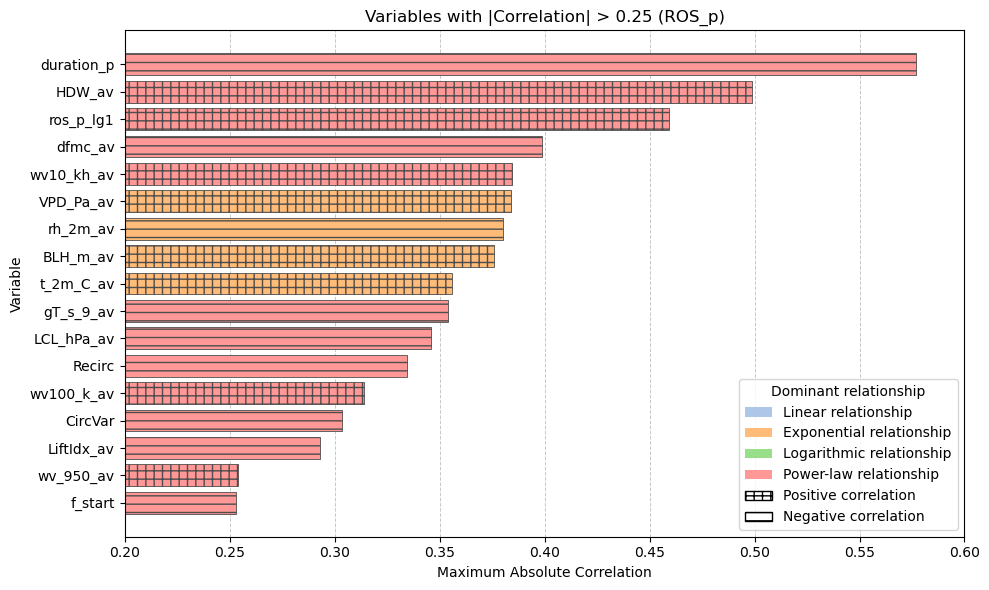

In [11]:
# =========================
# Bar plot of strongest correlations (refined style)
# =========================
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ---- Pastel color palette by relationship type ----
relation_colors = {
    "Relação Linear": "#AEC7E8",        # pastel blue
    "Relação Exponencial": "#FFBB78",   # pastel orange
    "Relação Logarítmica": "#98DF8A",   # pastel green
    "Relação Potência": "#FF9896"       # pastel red
}

plot_df["color"] = plot_df["Relation"].map(relation_colors)

# ---- Hatch mapping (lighter texture) ----
plot_df["hatch"] = plot_df["max_corr"].apply(lambda x: "+" if x > 0 else "-")

# =========================
# Plot
# =========================
fig, ax = plt.subplots(figsize=(10, max(6, 0.35 * len(plot_df))))

bars = ax.barh(
    plot_df["variable"],
    plot_df["max_abs_corr"],
    color=plot_df["color"],
    edgecolor="0.3",
    linewidth=0.6
)

# Apply lighter hatches
for bar, hatch in zip(bars, plot_df["hatch"]):
    bar.set_hatch(hatch * 2)

# ---- Gridlines ----
ax.grid(
    axis="x",
    linestyle="--",
    linewidth=0.7,
    alpha=0.7
)
ax.set_axisbelow(True)

# ---- Labels & title ----
ax.set_xlabel("Maximum Absolute Correlation")
ax.set_ylabel("Variable")
ax.set_title("Variables with |Correlation| > 0.25 (ROS_p)")
ax.set_xlim(0.2, 0.6)

ax.invert_yaxis()

# ---- Legend (English) ----
legend_elements = [
    Patch(facecolor=relation_colors["Relação Linear"], label="Linear relationship"),
    Patch(facecolor=relation_colors["Relação Exponencial"], label="Exponential relationship"),
    Patch(facecolor=relation_colors["Relação Logarítmica"], label="Logarithmic relationship"),
    Patch(facecolor=relation_colors["Relação Potência"], label="Power-law relationship"),
    Patch(facecolor="white", edgecolor="black", hatch="++", label="Positive correlation"),
    Patch(facecolor="white", edgecolor="black", hatch="--", label="Negative correlation"),
]

ax.legend(
    handles=legend_elements,
    title="Dominant relationship",
    loc="lower right",
    frameon=True
)

plt.tight_layout()
plt.show()
